In [258]:
!pip install folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from math import sin, cos, sqrt, atan2, radians

In [259]:
df = pd.read_csv("/content/drive/MyDrive/dados_colab/ponta_negra/asc_202308201757.csv", sep=";")

Separar os valores e adicionar as novas colunas

In [260]:
new_columns = df['valores'].str.split(';', expand=True)
new_column_names = [
    'contador',
    'hora',
    'minuto',
    'segundo',
    'dia',
    'mes',
    'ano',
    'latitude',
    'longitude',
    'temperatura',
    'umidade',
    'tamanho',
    'rssi']
new_columns.columns = new_column_names

# Concatenar as novas colunas no DataFrame original
df = pd.concat([df, new_columns], axis=1)

# Removendo colunas desnecessárias
df.drop(columns = ['valores'], inplace=True)
# df.head()

Criando o DataFrame do Mock

In [261]:
df_mock = pd.DataFrame(df[
      (df['dia'] == '4') &
      (df['mes'] == '5') &
      (df['ano'] == '6')
])
print(f'Qtd total {df.count()[0]}')
print(f'Qtd mock {df_mock.count()[0]}')
print(f'Qtd barco {df.count()[0] - df_mock.count()[0]}')

Qtd total 7793
Qtd mock 6156
Qtd barco 1637


Criando o DataFrame do barco

In [262]:
df_barco = pd.DataFrame(df[
      (df['dia'] != '4') |
      (df['mes'] != '5') |
      (df['ano'] != '6')
])

print(f'Qtd barco {df_barco.count()[0]}')

Qtd barco 1637


Formatando a data hora do GPS

In [263]:
def create_datetime(row):
    ano = str(row['ano']).zfill(4)
    mes = str(row['mes']).zfill(2)
    dia = str(row['dia']).zfill(2)
    hora = str(row['hora']).zfill(2)
    minuto = str(row['minuto']).zfill(2)
    segundo = str(row['segundo']).zfill(2)
    return f'{ano}-{mes}-{dia} {hora}:{minuto}:{segundo}'

df['data_hora_gps'] = df.apply(create_datetime, axis=1)
df.drop(columns = ['hora', 'minuto', 'segundo', 'dia', 'mes', 'ano'], inplace=True)

df_mock['data_hora_gps'] = df_mock.apply(create_datetime, axis=1)
df_mock.drop(columns = ['hora', 'minuto', 'segundo', 'dia', 'mes', 'ano'], inplace=True)

df_barco['data_hora_gps'] = df_barco.apply(create_datetime, axis=1)
df_barco.drop(columns = ['hora', 'minuto', 'segundo', 'dia', 'mes', 'ano'], inplace=True)

Exporta os dados para um arquivo em csv

In [264]:
# df.to_csv('todos.csv', index=False, sep=';')
# df_mock.to_csv('mock.csv', index=False, sep=';')
# df_barco.to_csv('barco.csv', index=False, sep=';')

Converte as colunas para os tipos int32, float64 e datetime

In [265]:
df_barco.reset_index(drop=True, inplace=True)
df_barco['id'] = df_barco['id'].astype(np.int32)
df_barco['data_hora_criacao'] = df_barco['data_hora_criacao'].astype(np.datetime64)
df_barco['data_hora_criacao'] = df_barco['data_hora_criacao'] - np.timedelta64(4, 'h')
df_barco['contador'] = df_barco['contador'].astype(np.int32)
df_barco['latitude'] = df_barco['latitude'].astype(np.float64)
df_barco['longitude'] = df_barco['longitude'].astype(np.float64)
df_barco['rssi'] = df_barco['rssi'].astype(np.int32)
# print(type(df_barco))
print(df_barco.dtypes)
# print(df_barco.columns.values)

id                            int32
data_hora_criacao    datetime64[ns]
contador                      int32
latitude                    float64
longitude                   float64
temperatura                  object
umidade                      object
tamanho                      object
rssi                          int32
data_hora_gps                object
dtype: object


# Criação do mapa

### Vermelho: horário da manhã
### Verde: horário da tarde

In [266]:
lat_fixo = -3.063791
lon_fixo = -60.102799

def gerar_mapa(df_mapa):
  m = folium.Map(location=[-3.084228, -60.104280], zoom_start=13)
  folium.Marker(location=[lat_fixo, lon_fixo]).add_to(m)

  # Adicione marcadores para cada coordenada na lista
  for lat, lon, dt_hr, id in zip(df_mapa.latitude.values, df_mapa.longitude.values, df_mapa.data_hora_criacao.values, df_mapa.id.values):
    if not np.isnan(lat) and not np.isnan(lon):
      data_comparacao = pd.to_datetime('2023-08-06 15:00:00')
      if data_comparacao > dt_hr: #De manhã
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,  # Tamanho do círculo
            color='red',  # Cor da borda do círculo
            fill=True,
            fill_color='red',  # Cor de preenchimento do círculo
            fill_opacity=0,  # Opacidade do preenchimento
            popup=id
        ).add_to(m)
      else:
        folium.CircleMarker(
            location=[lat, lon],
            radius=1,  # Tamanho do círculo
            color='green',  # Cor da borda do círculo
            fill=True,
            fill_color='green',  # Cor de preenchimento do círculo
            fill_opacity=0,  # Opacidade do preenchimento
            popup=id
        ).add_to(m)

  # Exiba o mapa
  return m

Mapa com todos os pacotes

In [267]:
m = gerar_mapa(df_barco)
# m.save('map_1.html')
m

Filtrando coordenadas inválidas

In [268]:
def dentro_do_retangulo(coord, cse, csd, cie):
    lat, lon = coord
    return cie[0] <= lat <= cse[0] and cie[1] <= lon <= csd[1]

def filtrar(df, cse, csd, cie, tipo):
  if tipo == 'fora':
    return df[df.apply(lambda row: dentro_do_retangulo(
        (row['latitude'], row['longitude']),
        cse, csd, cie
      ), axis=1)]
  else:
    return df[df.apply(lambda row: not dentro_do_retangulo(
        (row['latitude'], row['longitude']),
        cse, csd, cie
      ), axis=1)]

# Exclui as coordenadas que estão fora do retângulo
cse = (-3.042630, -60.152008)  # Canto superior esquerdo
csd = (-3.038695, -60.047361)  # Canto superior direito
cie = (-3.126097, -60.149938)  # Canto inferior esquerdo
df_filtrado = filtrar(df_barco, cse, csd, cie, 'fora')

# Exclui as coordenadas que estão dentro do retângulo
cse = (-3.108193, -60.124385)  # Canto superior esquerdo
csd = (-3.107824, -60.085976)  # Canto superior direito
cie = (-3.135308, -60.123857)  # Canto inferior esquerdo
df_filtrado = filtrar(df_filtrado, cse, csd, cie, 'dentro')

# Excluir coordenadas selecionadas em uma lista de ids
id_list = [2321, 1102, 5934, 2644, 6086, 5902, 5664, 1308]
df_filtrado = df_filtrado[~df_filtrado['id'].isin(id_list)]

df_filtrado.reset_index(drop=True, inplace=True)

Mapa com filtro

In [269]:
m = gerar_mapa(df_filtrado)
# m.save('map_2.html')
m

Calcula a distância entre as duas coordenadas

In [270]:
def CalculaMaiorDist(dt):
  maior = [0, 0, 0.0] # Índice, contador, valor

  for i in range(dt.count()[0]): # Encontra a maior distância percorrida
    if dt['distancia'][i] > maior[2]:
      maior[0] = i                  # Índice
      maior[1] = dt['contador'][i]  # Contador
      maior[2] = dt['distancia'][i] # Valor

  return maior

def Distancia(lat1, lon1, lat2, lon2):
  R = 6373.0 * 1000

  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

def PreencheDistancia(dt):
  dt['distancia'] = -1

  for i in range(dt.count()[0]):
      dt.loc[i , 'distancia'] = Distancia(dt['latitude'][i], dt['longitude'][i], lat_fixo, lon_fixo)

  return dt

PreencheDistancia(df_filtrado)
lista_maior = CalculaMaiorDist(df_filtrado)
print(f'Maior distância: {round(lista_maior[2], 2)} metros')

Maior distância: 6965.27 metros


Separa os dataframes no horário da manhã e da tarde

In [271]:
data_comparacao = pd.to_datetime('2023-08-06 15:00:00')

df_manha = pd.DataFrame(df_filtrado[df_filtrado["data_hora_criacao"] < data_comparacao])
df_manha.reset_index(drop=True, inplace=True)
df_manha['distancia'] = df_manha['distancia'].apply(lambda x: round(x, 2))
# df_manha.sort_values(by=['distancia'], inplace=True)
df_manha.to_csv('df_manha.csv', index=False, sep=';')

df_tarde = pd.DataFrame(df_filtrado[df_filtrado["data_hora_criacao"] > data_comparacao])
df_tarde.reset_index(drop=True, inplace=True)
df_tarde['distancia'] = df_tarde['distancia'].apply(lambda x: round(x, 2))
# df_tarde.sort_values(by=['distancia'], inplace=True)
df_tarde.to_csv('df_tarde.csv', index=False, sep=';')

Verifica o ponto entre a ida e a volta

In [272]:
metade_manha = df_manha[df_manha["id"] == 701].index[0]
print(f'Metade manhã: {metade_manha}')
metade_tarde = df_tarde[df_tarde["id"] == 4154].index[0]
print(f'Metade tarde: {metade_tarde}')

Metade manhã: 208
Metade tarde: 454


In [273]:
m = gerar_mapa(df_tarde)
m.save('img_tarde.html')
m

Função para plotagem do gráfico de RSSI vs Distância

In [274]:
def plot_rssi_dist(df, metade, horario):
  figura, ax = plt.subplots(figsize=(8, 4))

  arrRSSI = df["rssi"]
  arrDistancia = df["distancia"]

  menorIda = 0
  maiorIda = metade

  menorVolta = metade + 1
  maiorVolta = len(df) + 1

  yIda = arrRSSI[menorIda:maiorIda]
  xIda = arrDistancia[menorIda:maiorIda]

  yVolta = arrRSSI[menorVolta:maiorVolta]
  xVolta = arrDistancia[menorVolta:maiorVolta]

  ax.plot(xIda, yIda, 'b.', label='On the way')
  # ax.plot(xIda, yIda, label='Ida')
  ax.plot(xVolta, yVolta, 'r.', label='On the way back')
  # ax.plot(xVolta, yVolta, 'r.', label='Volta')
  ax.set_xlabel('Distance (meters)', size=14)
  # ax.set_xlabel('Distância (metros)', size=14)
  ax.set_ylabel('RSSI (dBm)', size=14)
  # ax.set_title('Spread Factor ' + str(i + 7), size=12)
  # ax.set_title('Fator de Espalhamento ' + str(i + 7), size=15)
  ax.legend()
  figura.savefig(f'rssi_dist_{horario}.png')
  figura.show()

Imprime o gráfico de RSSI vs Distância

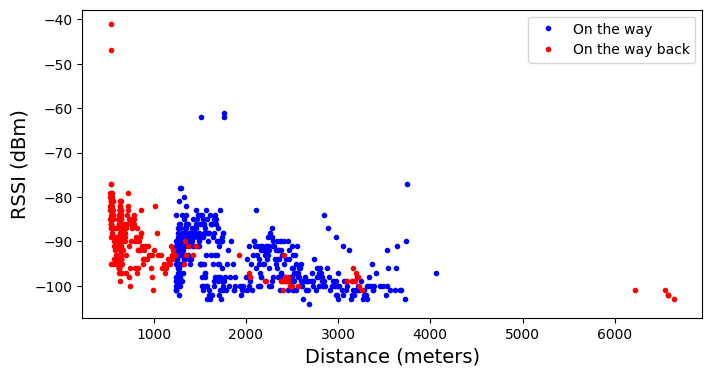

In [275]:
plot_rssi_dist(df_tarde, metade_tarde, "tarde")

Taxa de entrega de pacotes

In [276]:
# Ida = 1954 até 3377
# Volta = 5136 até 6123
df_ida = df_barco[(df_barco["id"] >= 1954) & (df_barco["id"] <= 3377)]
df_volta = df_barco[(df_barco["id"] >= 5136) & (df_barco["id"] <= 6123)]

ida_qtd_enviado = df_ida.iloc[-1].contador - df_ida.iloc[0].contador
print(f'Ida Qtd pacotes enviados: {ida_qtd_enviado}')
ida_qtd_recebido = df_ida.count()[0]
print(f'Ida Qtd pacotes recebidos: {ida_qtd_recebido}')
ida_taxa = round((ida_qtd_recebido / ida_qtd_enviado) * 100, 2)
print(f'Taxa de entrega de pacotes: {ida_taxa}%');

print("")

volta_qtd_enviado = df_volta.iloc[-1].contador - df_volta.iloc[0].contador
print(f'Volta Qtd pacotes enviados: {volta_qtd_enviado}')
volta_qtd_recebido = df_volta.count()[0]
print(f'Volta Qtd pacotes recebidos: {volta_qtd_recebido}')
volta_taxa = round((volta_qtd_recebido / volta_qtd_enviado) * 100, 2)
print(f'Taxa de entrega de pacotes: {volta_taxa}%')

Ida Qtd pacotes enviados: 882
Ida Qtd pacotes recebidos: 594
Taxa de entrega de pacotes: 67.35%

Volta Qtd pacotes enviados: 668
Volta Qtd pacotes recebidos: 348
Taxa de entrega de pacotes: 52.1%


Taxa de Bytes por segundo

In [277]:
tamanho_pacote = 52
ida_hora_inicial = df_barco[df_barco["id"] == 1954].data_hora_criacao.values[0]
ida_hora_final = df_barco[df_barco["id"] == 3377].data_hora_criacao.values[0]
ida_diferenca = ida_hora_final - ida_hora_inicial
ida_segundos = ida_diferenca.astype('timedelta64[s]').astype('float64')
print(f'Ida qtd segundos: {ida_segundos}')
ida_bytes = ida_qtd_recebido * tamanho_pacote
print(f'Ida qtd BYTES recebidos: {ida_bytes}')
print(f'Taxa de Bytes por segundo: {round(ida_bytes / ida_segundos, 2)}')

print("")

volta_hora_inicial = df_barco[df_barco["id"] == 5136].data_hora_criacao.values[0]
volta_hora_final = df_barco[df_barco["id"] == 6123].data_hora_criacao.values[0]
volta_diferenca = volta_hora_final - volta_hora_inicial
volta_segundos = volta_diferenca.astype('timedelta64[s]').astype('float64')
print(f'Volta qtd segundos: {volta_segundos}')
volta_bytes = volta_qtd_recebido * tamanho_pacote
print(f'Volta qtd BYTES recebidos: {volta_bytes}')
print(f'Taxa de Bytes por segundo: {round(volta_bytes / volta_segundos, 2)}')

Ida qtd segundos: 992.0
Ida qtd BYTES recebidos: 30888
Taxa de Bytes por segundo: 31.14

Volta qtd segundos: 752.0
Volta qtd BYTES recebidos: 18096
Taxa de Bytes por segundo: 24.06
